# Conversion Rate Analysis

### Introduction

One of the ways in which companies measure the success of their marketing efforts is the
percentage of people who progress from visiting their web site to accepting their
offers for products and services. We refer to this percentage as the
"conversion rate".

One day, at a marketing team meeting, someone says: "Our conversion rate is
down". Here we investigate whether this claim is true. We take a look at the conversion
data and try to understand what is happening to the conversion rate and determine
if the conversion rate is down and, if so, why it is down.

First we will import the necessary python programming language modules for the analysis. Then
we will import the conversion data for analysis.

In [29]:
# import necessary python modules for analysis
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from datetime import date

Run the cell below to import in the conversion data:

In [30]:
# import conversion_data.csv via pandas module
conversion_data = pd.read_csv("conversion_data.csv")

### Description of Conversion Data

Here we will see if the data is clean; that is, if are there any missing or suspicious values
within the data set.

In [31]:
# Get info on possible missing data and data types for each column
conversion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85335 entries, 0 to 85334
Data columns (total 4 columns):
_event             85335 non-null object
_time              85335 non-null int64
_traffic_source    85335 non-null object
_user_id           85335 non-null object
dtypes: int64(1), object(3)
memory usage: 2.6+ MB


Upon looking at the data manually and running the above .info method on the dataframe, there
doesn't seem to be any missing values within the data.

### What are the unique event types and traffic sources?

In [32]:
print("Event Types: ", conversion_data._event.unique())
print("Traffic Sources: ", conversion_data._traffic_source.unique())

Event Types:  ['visit' 'quote' 'application-completed' 'offer-accepted']
Traffic Sources:  ['c' 'b' 'a' 'd']


### Let's look at the distribution of events throughout the timeline of the data set:

In [33]:
event_counts = conversion_data._event.value_counts()
event_counts

visit                    60054
quote                    18313
application-completed     5729
offer-accepted            1239
Name: _event, dtype: int64

### Calculate and visualize the conversion rate over time

Here we will do time-series analysis to see if we can find out if our conversion rate changes over time or during specific time periods. First we will change our current timestamp data from "milliseconds since Unix Epoch" to actual dates in the month-day-year format.

We will also remove 6/27/2017 from our data set as it is the last day within our data set and only contains the first 40 minutes of observations/events on that day. Leaving this date in our data will skew our analyses and visualizations later.

In [34]:
# convert _time feature to date object
conversion_data['Date'] = pd.to_datetime(conversion_data._time, unit='ms')

# remove 6/27/2017 from conversion_data
conversion_data = conversion_data[conversion_data.Date <= '2017-06-27']

### Let's plot the daily conversion rate over time:


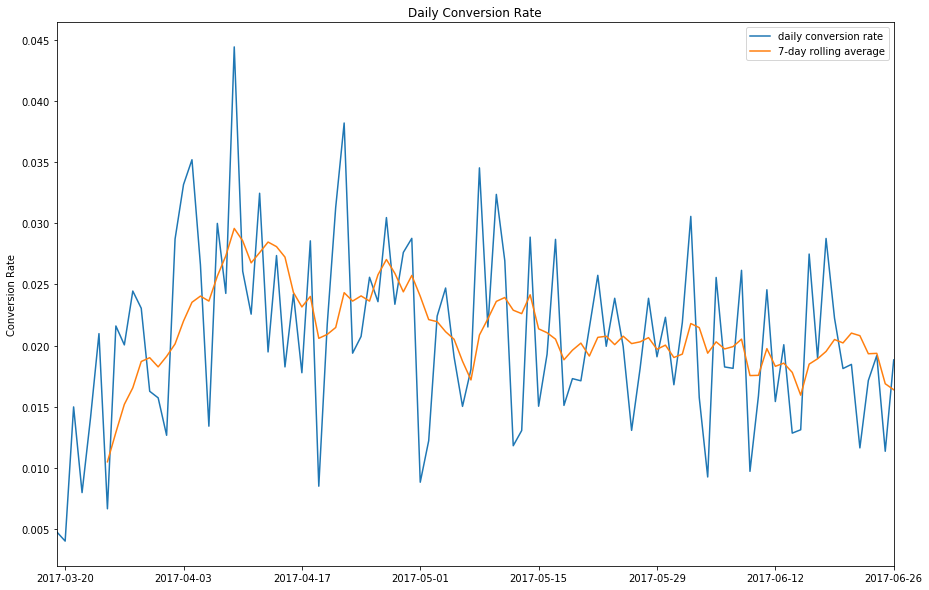

In [35]:
# convert Date column to only date object to groupby days later
conversion_data['Day'] = conversion_data['Date'].dt.date

# group the conversion data by Day and by _event to get event totals per day: daily_events
daily_events = conversion_data.groupby([conversion_data.Day, conversion_data._event])[
    '_traffic_source'].count().unstack()

# create daily conversion rate column
daily_events['conversion_rate'] = daily_events['offer-accepted'] / daily_events['visit']

# plot the dataframe grouped by Day and by _event: daily_events
ax = daily_events.plot(y=['conversion_rate'], title="Daily Conversion Rate", figsize=(15,10));

# plot the 7-day rolling average of the daily conversion rate
daily_events.rolling(7).mean()['conversion_rate'].plot()

# set the xlable
ax.set_xlabel('')

# set the xlable
ax.set_ylabel('Conversion Rate')

# set the legend
ax.legend(['daily conversion rate', '7-day rolling average']);

It looks like the daily conversion rate generally increases from the middle of March 2017 to the beginning of April 2017 where the 7-day rolling average peaked around 2.9%, but then decreases at a seemingly slow but steady rate to a 7-day rolling average of around 1.7% by June 26th, 2017 (where the data set ends).

Let's see if we can look at the daily event activity to see if we can find out *why* the conversion rate decreases.

### Plot the daily event activity

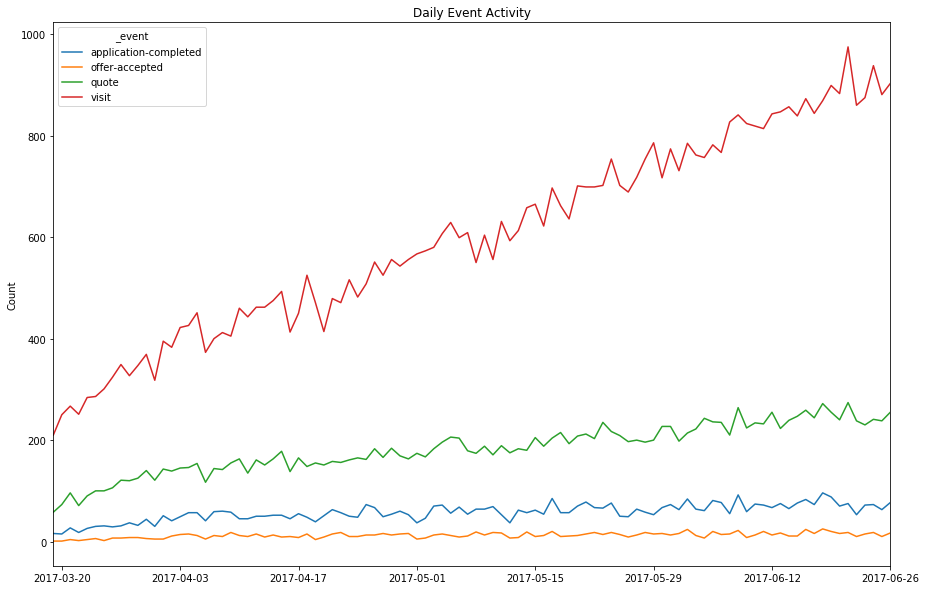

In [36]:
# plot the dataframe grouped by Day and by _event: daily_events
ax = daily_events.drop(['conversion_rate'], axis=1).plot(title="Daily Event Activity", figsize=(15,10));

# set the xlable
ax.set_xlabel('')

# set the y-label
ax.set_ylabel('Count');

Interesting! The plot shows that visits increased steadily over time while offers accepted remained relatively constant after increasing slightly from the middle of March 2017 to the beginning of April 2017. The steady increase in visits with a relatively constant or stagnant number of accepted offers over time may explains the overall decrease in conversion rate after the first week of April 2017.  

However, this display of event activity doesn't necessarily explain why the conversion rate increases in the beginning (from the middle of March 2017 to the beginning of April 2017). Let's take a closer look at accepted offers on a lower scale to see if we can get more insight as to how and why the conversion rate increases at first. 

### Let's zoom in on the daily accepted offers:

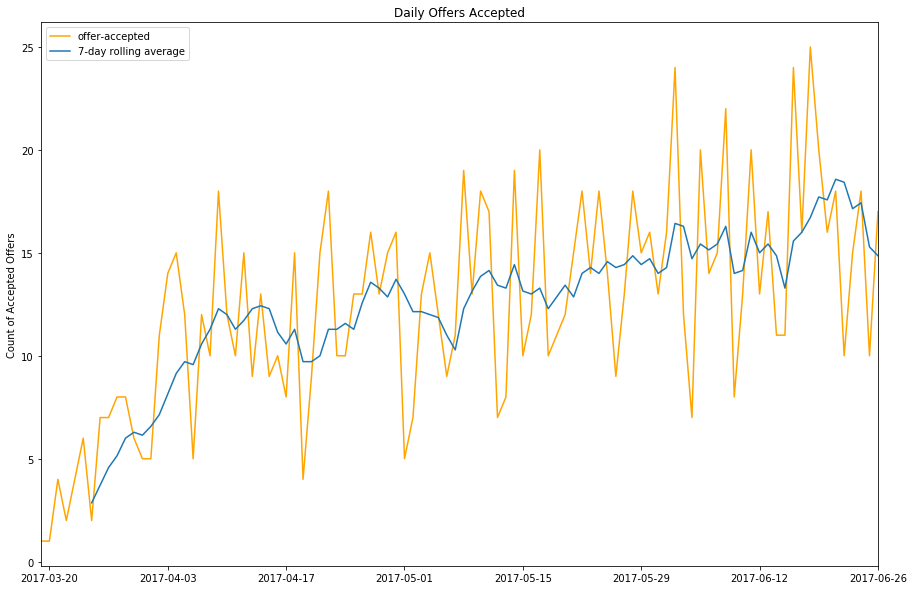

In [37]:
# plot the dataframe grouped by Day and by _event: daily_events
ax = daily_events['offer-accepted'].plot(title="Daily Offers Accepted", figsize=(15,10), color='orange');

# plot the 7-day rolling average of the daily conversion rate
daily_events.rolling(7).mean()['offer-accepted'].plot()

# set the xlable
ax.set_xlabel('')

# set the legend
ax.legend(['offer-accepted', '7-day rolling average'])

# set the xlabel
ax.set_xlabel('')

# set the y-label
ax.set_ylabel('Count of Accepted Offers');

It looks like in the beginning, accepted offers were generally increasing from very small amounts (less than 5) to upwards of 15 accepted offers at the beginning of April 2017. The rate at which the accepted offers were increasing during this time was higher than the rate at which the visits were increasing during this time, so the overall conversion rate increased during this time as the conversion rate quotient contained higher numerator than denominator: # of Accepted Offers / # of Visits.

Looking more at these daily accepted offers, it can also be seen that accepted offers actually seem to slightly increase (albeit at a lower rate than in the beginning) after around the first week of April 2017. However, since visits increased at a higher rate during this time, the overall conversion rate decreased after its initial bump. The total daily accepted offers seem to show an overall logarithmic growth rate over time. 

### Now let's see which source bring produces the most traffic to the website:

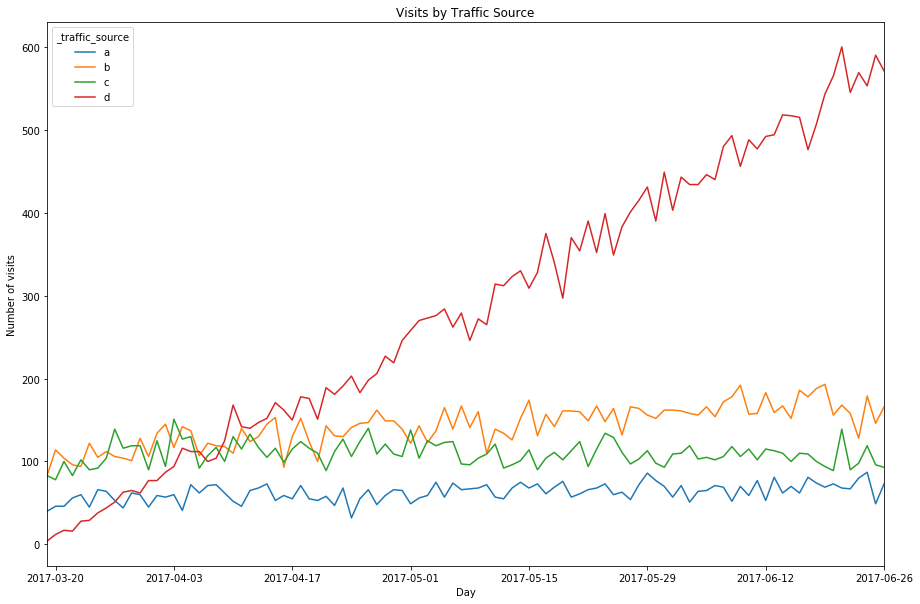

In [38]:
# group conversion_data by Day and _traffic_source to get total 
traffic_sources = conversion_data[conversion_data._event=='visit'].groupby([
    'Day', '_traffic_source'])['_event'].count().unstack()

# plot the daily activity for each individual traffic source 
ax = traffic_sources.plot(title="Visits by Traffic Source", figsize=(15,10))

# set the y label
ax.set_ylabel('Number of visits');

Interestingly, we see that the number of visits per day brought on by traffic source 'd' steadily increases at a seemingly linear rate over time while the number of visits brought on by each other traffic source only slightly increase over time. The increase in the overall number of visits we saw in an earlier visual seems to be heavily influenced by the 'd' traffic source.

### Now let's look at the daily accepted offers from each traffic source

Run the cell below to create the dataframe used for the plotting of daily accepted offers and daily conversion rate for each traffic source below:

In [39]:
# group by Day, _event, and _traffic_source
daily_traffic = conversion_data.groupby([
    conversion_data.Day, 
    conversion_data._traffic_source,
    conversion_data._event])[
    '_traffic_source'].count().unstack().fillna(0)

# create conversion rate column and add it to daily_traffic df
daily_traffic['conversion_rate'] = daily_traffic['offer-accepted'] / daily_traffic['visit']

# plot the 7-day rolling average of the daily conversion rates
daily_traffic['avg_conv_rate'] = daily_traffic.rolling(30).mean()['conversion_rate'].fillna(0)
#daily_traffic.xs('d', level=1)['avg_acc_offer']

### Run the cell below to plot the daily accepted offers for each traffic source:

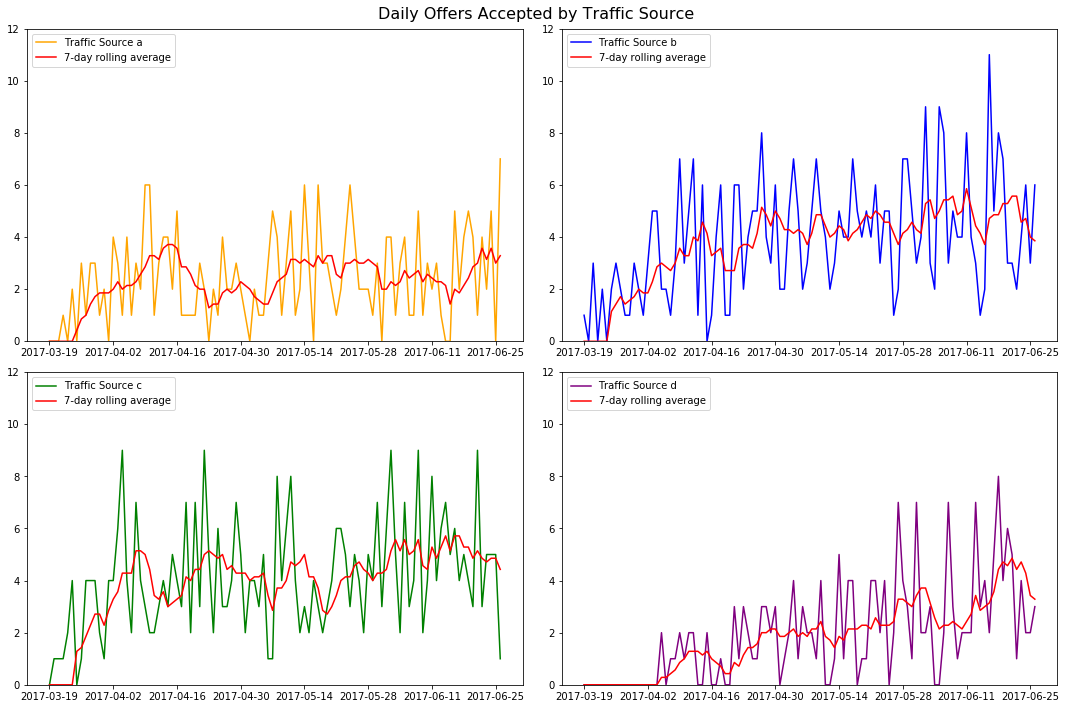

In [40]:
# create ax object for subplots
ax = plt.subplots(2,2,figsize=(15,10), sharex='row', sharey='col')

# plot conversion rate of traffic source 'a' in orange
plt.suptitle("Daily Offers Accepted by Traffic Source", fontsize=16)
plt.subplot(2,2,1)
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('a', level=1)['offer-accepted'],
         color='orange')
# plot 7-day rolling average daily accepted offers
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('a', level=1).rolling(7).mean()['offer-accepted'].fillna(0),
         color='red')
plt.legend(['Traffic Source a', '7-day rolling average'], loc='upper left')
plt.ylim([0, 12])

# plot conversion rate of traffic source 'b' in blue
plt.subplot(2,2,2)
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('b', level=1)['offer-accepted'], 
         color='blue')
# plot 7-day rolling average daily accepted offers
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('b', level=1).rolling(7).mean()['offer-accepted'].fillna(0),
         color='red')
plt.legend(['Traffic Source b', '7-day rolling average'], loc='upper left')
plt.ylim([0, 12])

# plot conversion rate of traffic source 'c' in green
plt.subplot(2,2,3)
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('c', level=1)['offer-accepted'],
         color='green')
# plot 7-day rolling average daily accepted offers
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('c', level=1).rolling(7).mean()['offer-accepted'].fillna(0), 
         color='red')
plt.legend(['Traffic Source c', '7-day rolling average'], loc='upper left')
plt.ylim([0, 12])

# plot conversion rate of traffic source 'd' in purple
plt.subplot(2,2,4)
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('d', level=1)['offer-accepted'], 
         color='purple')

# plot 7-day rolling average daily accepted offers
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('d', level=1).rolling(7).mean()['offer-accepted'].fillna(0),
         color='red')
plt.legend(['Traffic Source d', '7-day rolling average'], loc='upper left')
plt.ylim([0, 12])

plt.tight_layout()
plt.subplots_adjust(top=0.95)

The subplotting of the daily accepted offers (by traffic source) above shows that although source 'd' produces the most traffic to the website over time (and at the most positive, linear rate), the amount of daily accepted offers produced from this source were lower than each of the other traffic sources. Outside of traffic source 'd', the 7-day rolling average of daily accepted offers of each traffic source shows a sharp increase in the beginning of the timeline and then a tapering off at a low, but increasing rate. This corresponds to the seemingly logarithmic growth rate we saw earlier in total daily offers accepted.

In contrast, traffic source d did not produce accepted offers much at all during the beginning of the time window (middle-end of March 2017), but it did seem to increase at a linear rate from then on.

### Finally, let's look at the daily conversion rates for each traffic source

Run the cell below to plot the daily conversion rates for each traffic source:

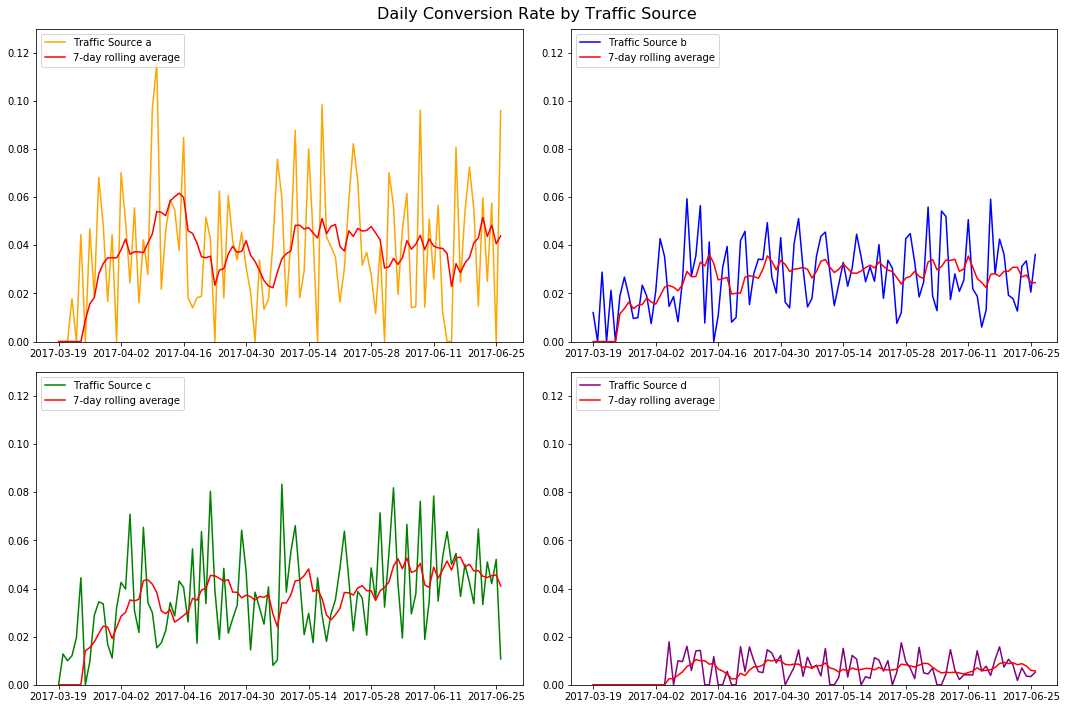

In [41]:
# create ax object for subplots
ax = plt.subplots(2,2,figsize=(15,10), sharex='row', sharey='col')

# plot conversion rate of traffic source 'a' in orange
plt.suptitle("Daily Conversion Rate by Traffic Source", fontsize=16)
plt.subplot(2,2,1)
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('a', level=1)['conversion_rate'], 
         color='orange')
# plot the 7-day rolling average
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('a', level=1).rolling(7).mean()['conversion_rate'].fillna(0),
         color='red')

plt.legend(['Traffic Source a', '7-day rolling average'], loc='upper left')
plt.ylim([0.00, 0.13])

# plot conversion rate of traffic source 'b' in blue
plt.subplot(2,2,2)
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('b', level=1)['conversion_rate'], 
         color='blue')
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('b', level=1).rolling(7).mean()['conversion_rate'].fillna(0), 
         color='red')
plt.legend(['Traffic Source b', '7-day rolling average'], loc='upper left')
plt.ylim([0.00, 0.13])

# plot conversion rate of traffic source 'c' in green
plt.subplot(2,2,3)
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('c', level=1)['conversion_rate'],
         color='green')
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('c', level=1).rolling(7).mean()['conversion_rate'].fillna(0),
         color='red')
plt.legend(['Traffic Source c', '7-day rolling average'], loc='upper left')
plt.ylim([0.00, 0.13])

# plot conversion rate of traffic source 'd' in purple
plt.subplot(2,2,4)
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('d', level=1)['conversion_rate'],
         color='purple')
plt.plot(daily_traffic.index.get_level_values(0).unique(),
         daily_traffic.xs('d', level=1).rolling(7).mean()['conversion_rate'].fillna(0),
         color='red')
plt.legend(['Traffic Source d', '7-day rolling average'], loc='upper left')
plt.ylim([0.00, 0.13])

plt.tight_layout()
plt.subplots_adjust(top=0.95)

From the above subplots of daily conversion rate of each traffic source, it is evident that traffic source d produces the lowest conversion rate over time with a virtual lack of growth over time indicated by a relatively constant 7-day rolling average. 

Each other traffic source seems to have higher rates over time than traffic source d and have overall logarithmic growth rates. 

### Key Findings

* In the beginning, the daily conversion rate increases from the middle of March 2017 to an average daily high of around 3% by the beginning of April 2017. 


* This initial increase in daily conversion rate can be explained by the amount of daily accepted offers increasing at a large rate relative to the rate in which the number of daily customer visits increases.


* The conversion rate *does* show steady decrease after the beginning of April 2017, however, to a 7-day rolling average low of around 1.6% by the end of June 2017.


* Traffic source 'd' steadily produces a linearly increasing number of visitors while each other traffic source produces logarithmic trends in vistors to the website, which results in source 'd' producing three times more vistors than the second highest producing source by the end of June 2017.


* However, although increasing at a low, linear rate after the first week of April 2017, traffic source 'd' produces the least amount of accepted offers over time and a significantly lower conversion rate over time than each of the other traffic sources.


* Each of the traffic source outside of source 'd' have a relatively high conversion rate over time with a logarithmic growth rate.

### Conclusion

We should be seeing somewhat of a logarithmic growth rate in our daily conversion rate, but with traffic source 'd' producing a very high proportion of visits (at a linearly increasing rate) with a low proportion of offers accepted, the source's subsequential low conversion rate *does* weigh the overall conversion rate down; specifically, at a steady rate from a 7-day rolling average of around 2.9% in April 2017 to a 7-day rolling average of around 1.7% by the end of June 2017.